In [6]:
import pandas as pd
import numpy as np
import seaborn as sbn
import statistics
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from datetime import datetime

current_date = datetime.now()
formatted_date = current_date.strftime("%Y.%m.%d")

root = '/Users/grantongo/Desktop/nature methods/figures'

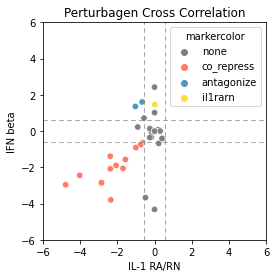

In [33]:
# figure 5c 
volcano_all = pd.read_csv(f'{root}/data/pbmc/pbmc_all_responses_2025.01.22.csv')

fig, ax = plt.subplots(1,1, figsize=(4,4), gridspec_kw={'wspace':0.3, 'hspace':0.3}) # ax = axs[0]

pert_x = 'IL-1 RA RN'
pert_y = 'IFN beta'
stim = ['control'] #'LPS','PolyIC','PMAi','ConA',
log2fc_thresh = np.log2(1.5)


df_co = volcano_all[(volcano_all.cytokine.isin([pert_x,pert_y])) & (volcano_all.stimulus.isin(stim))]
df_pivot = pd.pivot_table(df_co, columns='cytokine', index='sensor', values = 'log2fc').reset_index()

# figure
df_pivot['markercolor'] = 'none'
df_pivot.loc[(df_pivot[pert_x] >  log2fc_thresh) & (df_pivot[pert_y] >  log2fc_thresh),'markercolor'] = 'co_enhance'
df_pivot.loc[(df_pivot[pert_x] <- log2fc_thresh) & (df_pivot[pert_y] <- log2fc_thresh),'markercolor'] = 'co_repress'
df_pivot.loc[(df_pivot[pert_x] >  log2fc_thresh) & (df_pivot[pert_y] <- log2fc_thresh),'markercolor'] = 'antagonize'
df_pivot.loc[(df_pivot[pert_x] <- log2fc_thresh) & (df_pivot[pert_y] >  log2fc_thresh),'markercolor'] = 'antagonize'
df_pivot.loc[df_pivot.sensor=='IL-1 RA RN', 'markercolor'] = 'il1rarn'

ax = sbn.scatterplot(data=df_pivot, x=pert_x, y=pert_y,
                     hue='markercolor',
                     s=40,
                     palette=dict(none='#808080ff', 
                                  co_enhance='#7edf7fff', 
                                  co_repress='#ff7b63ff', 
                                  antagonize='#4c99c6ff',
                                  il1rarn='#fbdd40ff'),
                     #legend=None, 
                     ax=ax)

ax.set_title('Perturbagen Cross Correlation')
ax.set_xlabel('IL-1 RA/RN')

lim_min, lim_max = -6, 6
ax.add_line(mlines.Line2D([lim_min, lim_max], [-log2fc_thresh, -log2fc_thresh], color='gray', alpha=0.7, dash_capstyle='round',dashes=[4],linewidth=1))
ax.add_line(mlines.Line2D([lim_min, lim_max], [log2fc_thresh, log2fc_thresh], color='gray', alpha=0.7, dash_capstyle='round',dashes=[4],linewidth=1))
ax.add_line(mlines.Line2D([log2fc_thresh, log2fc_thresh], [lim_min,lim_max], color='gray', alpha=0.7, dash_capstyle='round',dashes=[4],linewidth=1))
ax.add_line(mlines.Line2D([-log2fc_thresh, -log2fc_thresh], [lim_min,lim_max], color='gray', alpha=0.7, dash_capstyle='round',dashes=[4],linewidth=1))
ax.set_xlim(lim_min,lim_max)
ax.set_ylim(lim_min,lim_max)

fig.savefig(f'{root}/figure 5/svg_figure.5.c_perturbagen.cross.correlation_{formatted_date}.svg')

In [34]:
def remove_spiked_cytokines(df):
    
    df.cytokine = df['cytokine'].replace('/', ' ', regex=True)
    df = df[(df.donor != 7) & (df.donor != 8)]    

    # known cross reactivities due to shared homology 
    cross_reactives = {"CXCL12 (alpha)" : ["CXCL12 (beta)"],
                       "CXCL12 (beta)" : ["CXCL12 (alpha)"],
                       "IL-12 p40" : ["IL-12 p70", "IL-23"], 
                       "IL-12 p35" : ["IL-12 p70"]}

    # cytokine spiked signal replaced with signal from matched control for donor, stimulus, and stimulus concentration
    for donor in df.donor.unique():
        for stim in df.stimulus.unique():
            for stimconc in set(df[(df.stimulus==stim) & (df.donor==donor)]['stimulus_concentration']):
                for sensor in sensors:

                    df_control = df[(df.stimulus==stim) & 
                                    (df.stimulus_concentration==stimconc) & 
                                    (df.cytokine=='control') & 
                                    (df.donor==donor)]
                    control_signal = np.nanmedian(df_control[sensor].astype(float))

                    # when a sensor detects it's spiked in cytokine, replace with the matched control signal
                    if sensor in set(df.cytokine):
                        
                        df.loc[(df.stimulus==stim) & 
                               (df.stimulus_concentration==stimconc) & 
                               (df.cytokine==sensor) & 
                               (df.donor==donor),sensor] = control_signal

                    # when the sensor has known cross reactivities, replace with the matched control as well
                    if sensor in cross_reactives:
                        for sensor_cr in cross_reactives[sensor]:
                            df.loc[(df.stimulus==stim) & 
                                   (df.stimulus_concentration==stimconc) & 
                                   (df.cytokine==sensor_cr) & 
                                   (df.donor==donor),sensor] = control_signal

    return df
def drop_outliers(df): 
    
    h_in, w_in = df.shape

    # next remove rows of outliers (where all nans)
    df = df.dropna(axis=0, subset=sensors, how='all')

    nans = df.isna().sum()
    mode = statistics.mode(nans[nans!=0])

    init_columns = df.columns
    
    # remove sensors with high number of nan
    df = df.loc[:,df.isna().sum() < mode+10]

    print(f'columns dropped: {[x for x in init_columns if x not in df.columns]}')
    
    # drop wells with outliers
    df = df.dropna(axis=0, how='any')

    h_out, w_out = df.shape
    
    print(f'columns dropped: {w_in-w_out} \noutliers dropped: {h_in-h_out}\n')
    
    return df

sensors = pd.read_csv(f'{root}/data/pbmc/pbmc_sensors.csv', header=None)[0]

df_SNR = pd.read_csv(f'{root}/data/pbmc/pbmc_snr.csv')
df_SNR = remove_spiked_cytokines(df_SNR)
df_SNR = drop_outliers(df_SNR)

df_PGML = pd.read_csv(f'{root}/data/pbmc/pbmc_pgml_imputed.csv')
df_PGML = remove_spiked_cytokines(df_PGML)
df_PGML = drop_outliers(df_PGML)

sensors = [x for x in df_SNR.columns if x in sensors.tolist()]
print(f'total sensors: {len(sensors)}')

columns dropped: []
columns dropped: 0 
outliers dropped: 16

columns dropped: []
columns dropped: 0 
outliers dropped: 16

total sensors: 191


In [35]:
def foldchange(df_SNR, df_PGML, stims, cytos, fc_thresh=1.5, pval_thresh=0.05):

    foldchange_all = pd.DataFrame()
    foldchange_significant = pd.DataFrame()

    for stim in stims:
        #print(stim)
        for cyto in cytos:
            #print(f'\tcyto')
            for stimconc in df_SNR.stimulus_concentration[(df_SNR.stimulus == stim) & (df_SNR.cytokine == cyto)].unique().tolist():
                for donor in [1, 2, 3, 4, 5, 6]: 
                    testgroup_snr = df_SNR[(df_SNR.stimulus == stim) & 
                                           (df_SNR.cytokine == cyto) & 
                                           (df_SNR.donor == donor) &
                                           (df_SNR.stimulus_concentration == stimconc)]          
                    controlgroup_snr = df_SNR[(df_SNR.stimulus == stim) & 
                                              (df_SNR.cytokine == 'control') & 
                                              (df_SNR.donor == donor) &
                                              (df_SNR.stimulus_concentration == stimconc)]             
                    testgroup_pgml = df_PGML[(df_PGML.stimulus == stim) & 
                                             (df_PGML.cytokine == cyto) & 
                                             (df_PGML.donor == donor) & 
                                             (df_PGML.stimulus_concentration == stimconc)]             
                    controlgroup_pgml = df_PGML[(df_PGML.stimulus == stim) & 
                                                (df_PGML.cytokine == 'control') & 
                                                (df_PGML.donor == donor) & 
                                                (df_PGML.stimulus_concentration == stimconc)]
                    for sensor in sensors:
                        foldchange = pd.DataFrame()
                        if sensor in df_SNR.columns:
                            # calculate pvalue based on SNR
                            fval, pval = stats.f_oneway(testgroup_snr[sensor], controlgroup_snr[sensor])
                            qval = -1*np.log10(pval)
                            # calculate foldchange using pg/ml
                            fc = statistics.median(testgroup_pgml[sensor])/statistics.median(controlgroup_pgml[sensor]) 
                            log2fc = np.log2(abs(fc))

                            foldchange = pd.DataFrame(data = {'cytokine':[cyto],
                                                               'stimulus':[stim],
                                                               'stimulus_concentration':[stimconc],
                                                               'sensor':[sensor], 
                                                               'pvalue':[pval], 
                                                               'qvalue':[qval], 
                                                               'donor':[donor],
                                                               'foldchange':[fc],
                                                               'log2fc':[log2fc],
                                                               'len_testgroup':[len(testgroup_pgml)],
                                                               'len_controlgroup':[len(controlgroup_pgml)]
                                                            })
                            foldchange = foldchange.replace(np.inf, np.nan)

                            foldchange_all = pd.concat([foldchange_all,foldchange],axis=0)

                            foldchange_significant = pd.concat([foldchange_significant,
                                                    foldchange[(foldchange.log2fc<-np.log2(abs(fc_thresh))) & 
                                                               (foldchange.qvalue>-np.log10(pval_thresh))],
                                                    foldchange[(foldchange.log2fc>np.log2(abs(fc_thresh))) & 
                                                               (foldchange.qvalue>-np.log10(pval_thresh))]],
                                                    axis=0)
        
    return foldchange_all, foldchange_significant
        
foldchange_all, foldchange_significant = foldchange(df_SNR, 
                                                    df_PGML, 
                                                    stims=df_SNR.stimulus.unique(), 
                                                    cytos=['C5 C5a','CX3CL1'])

print(f'foldchange_all: {len(foldchange_all)}')
print(f'foldchange_significant: {len(foldchange_significant)}')

foldchange_significant.to_csv(f'{root}/data/pbmc/pbmc_foldchange_significant_{formatted_date}.csv')
foldchange_all.to_csv(f'{root}/data/pbmc/pbmc_foldchange_all_{formatted_date}.csv')

foldchange_all: 27504
foldchange_significant: 259


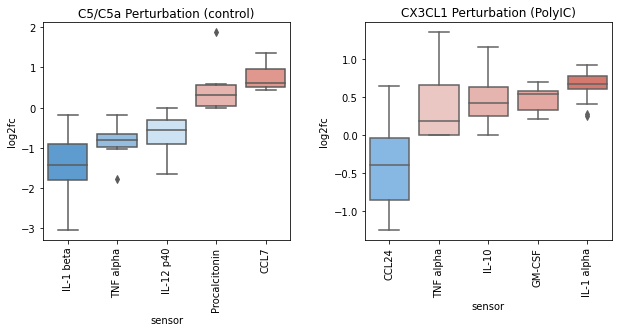

In [36]:
# foldchange of C5/C5a and CX3CL1 perturbations

stim_C5C5a = 'control'
stim_CX3CL1 = 'PolyIC'

df_C5C5a = foldchange_all[(foldchange_all.sensor.isin(['IL-1 beta','TNF alpha','IL-12 p40','CCL7','Procalcitonin'])) & 
                          (foldchange_all.cytokine=='C5 C5a') & 
                          (foldchange_all.stimulus==stim_C5C5a)].sort_values('log2fc')
df_CX3CL1 = foldchange_all[(foldchange_all.sensor.isin(['TNF alpha','IL-10','IL-1 alpha','CCL24','GM-CSF'])) & 
                          (foldchange_all.cytokine=='CX3CL1') & 
                          (foldchange_all.stimulus==stim_CX3CL1)].sort_values('log2fc')

cmap = sbn.color_palette("RdBu_r", 5)

fig, ax = plt.subplots(1,2,figsize=(10.2,4), gridspec_kw={'wspace':0.3,'hspace':0.7})
ax = ax.ravel()

ax[0] = sbn.boxplot(data=df_C5C5a,
                      x='sensor',
                      y='log2fc',
                      #errorbar=('ci',95),
                      ax=ax[0], 
                      palette= ['#4B9CE2','#88BEEC','#C7E2F9','#EEADA5','#EC8C81']
                   )
ax[1] = sbn.boxplot(data=df_CX3CL1,
                      x='sensor',
                      y='log2fc',
                      ax=ax[1], 
                      palette=['#77B9F2','#F2C2BD','#EEADA5','#EE9F96','#E66A5C']
                   )
ax[0].set_title(f'C5/C5a Perturbation ({stim_C5C5a})')
ax[1].set_title(f'CX3CL1 Perturbation ({stim_CX3CL1})')

ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)

fig.savefig(f'{root}/figure 5/svg_figure.5.d.e_foldchange.perturbations_{formatted_date}.svg')
